<a href="https://colab.research.google.com/github/ostroskianais/yield-prediction/blob/main/yield_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_decision_forests

# Data

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
import pandas as pd # For reading .csv
from datetime import datetime # For knowing how long does each read/write take

train_csv = pd.read_csv("/content/drive/MyDrive/yield-data/train.csv").drop('medianArea',1)
test_csv = pd.read_csv("/content/drive/MyDrive/yield-data/test.csv").drop('medianArea',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1):
  #Creates a tf.data dataset from pandas dataframe
  dataframe = dataframe.copy()
  labels = dataframe.pop('yield')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  # Process a batch-size at a time
  ds = ds.batch(batch_size)
  # Prefetching allows us to optimise fethcing of data and training
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
train_ds = df_to_dataset(train_csv, shuffle=False)
test_ds = df_to_dataset(test_csv, shuffle=False)
train_ds

<PrefetchDataset element_spec=({'NDVI': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tmean': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'medianArea': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'vpdmax': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'ppt': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of NDVI: ', train_features['NDVI'])
print('A batch of labels: ', label_batch)

Every feature: ['NDVI', 'tmean', 'medianArea', 'vpdmax', 'ppt']
A batch of NDVI:  tf.Tensor([0.87556317], shape=(1,), dtype=float64)
A batch of labels:  tf.Tensor([39.], shape=(1,), dtype=float64)


In [ ]:
all_inputs = []

columns = ['NDVI', 'tmean', 'medianArea', 'vpdmax', 'ppt']
for column_name in columns:
  column = tf.keras.Input(shape=(1,), name=column_name)
  all_inputs.append(column)

all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'NDVI')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tmean')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'medianArea')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'vpdmax')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ppt')>]

In [ ]:
all_features = tf.keras.layers.concatenate(all_inputs)
# output_layer = tf.keras.layers.Dense(300)
x = tf.keras.layers.Dense(10, activation="relu")(all_features)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1)(x)

# Random Forest

In [18]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_csv, label="yield", task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_csv, label="yield", task=tfdf.keras.Task.REGRESSION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [75]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, num_trees=300)

# Train the model.
model_1.fit(x=train_ds, validation_split=0.2)

Use /tmp/tmp75j9xq1f as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.323660. Found 800 examples.
Training model...
Model trained in 0:00:01.132287
Compiling model...
Model compiled.


In [76]:
model_1.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (4):
	NDVI
	ppt
	tmean
	vpdmax

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  9.109025 ################
    2.  "vpdmax"  3.882895 ######
    3.   "tmean"  3.406346 #####
    4.     "ppt"  1.788405 ##
    5.    "NDVI"  0.474034 

Variable Importance: NUM_AS_ROOT:
    1.  "NDVI" 195.000000 ################
    2.   "ppt" 85.000000 #####
    3. "tmean" 20.000000 

Variable Importance: NUM_NODES:
    1.   "NDVI" 9794.000000 ################
    2.  "tmean" 9615.000000 ############
    3. "vpdmax" 9038.000000 ###
    4.    "ppt" 8854.000000 

Variable Importance: SUM_SCORE:
    1.   "NDVI" 9201441.845216 ##########

In [77]:
model_1.compile(#loss=tf.keras.metrics.mean_squared_error,
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         "mean_squared_error"])

evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 163ms/step - loss: 0.0000e+00 - rmse: 5.3595 - mean_squared_error: 28.7239

loss: 0.0000
rmse: 5.3595
mean_squared_error: 28.7239


In [78]:
pred_test = model_1.predict(test_ds)
pred_train = model_1.predict(train_ds)

1/1 [==============================] - 0s 60ms/step


(1.0999999999999996, 75.9, 1.0999999999999996, 75.9)

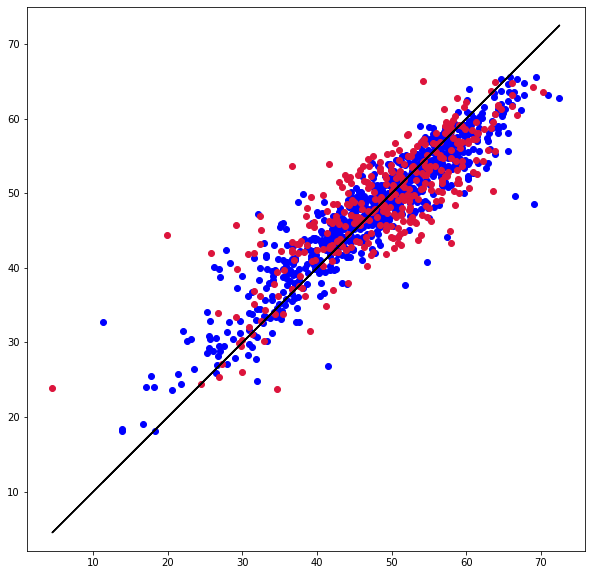

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(train_csv["yield"], train_csv["yield"], c='black')
plt.plot(test_csv["yield"], test_csv["yield"], c='black')
plt.scatter(train_csv["yield"], pred_train, c='blue')
plt.scatter(test_csv["yield"], pred_test, c='crimson')
plt.axis('equal')

In [80]:
from scipy.stats import pearsonr
corr_train = pearsonr(train_csv["yield"], pred_train)
corr_test = pearsonr(test_csv["yield"], pred_test)

print("Train R2: ", corr_train)
print("Test R2: ", corr_test)

Train R2:  (array([0.929177450273111], dtype=object), 0.0)
Test R2:  (array([0.8242512022755414], dtype=object), 5.4364465216263646e-86)


# Visualize trees

In [12]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=8)

# Save model

In [ ]:
OUTPUT_BUCKET = "my_bucket"
MODEL_DIR = 'gs://' + OUTPUT_BUCKET + '/randomForest_v1'
model_1.save(MODEL_DIR, save_format='tf')

# Predict on pixel samples

In [81]:
import glob
all_files = glob.glob("/content/drive/MyDrive/pixel-samples/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files))
pixel_df = df.drop(['system:index', '.geo'], 1)
print(pixel_df)

          NDVI       ppt     tmean    vpdmax
0     0.905716  0.262071  0.293957  0.259374
1     0.707675  0.104162  0.218346  0.359268
2     0.931551  0.203846  0.300541  0.298647
3     0.906061  0.290051  0.330722  0.325552
4     0.910585  0.291236  0.331501  0.327365
...        ...       ...       ...       ...
4928  0.920177  0.670852  0.644762  0.526448
4929  0.927792  0.645546  0.649229  0.468212
4930  0.905540  0.619921  0.675105  0.418915
4931  0.868758  0.534144  0.705393  0.462084
4932  0.915016  0.536381  0.705949  0.525964

[183218 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [82]:
pixel_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pixel_df)
pixel_ds

<PrefetchDataset element_spec={'NDVI': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'ppt': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tmean': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'vpdmax': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}>

In [83]:
pred_pixel = model_1.predict(pixel_ds)
pred_pixel

184/184 [==============================] - 5s 29ms/step


array([[51.7841  ],
       [25.457336],
       [59.944138],
       ...,
       [53.092293],
       [49.509132],
       [51.009563]], dtype=float32)

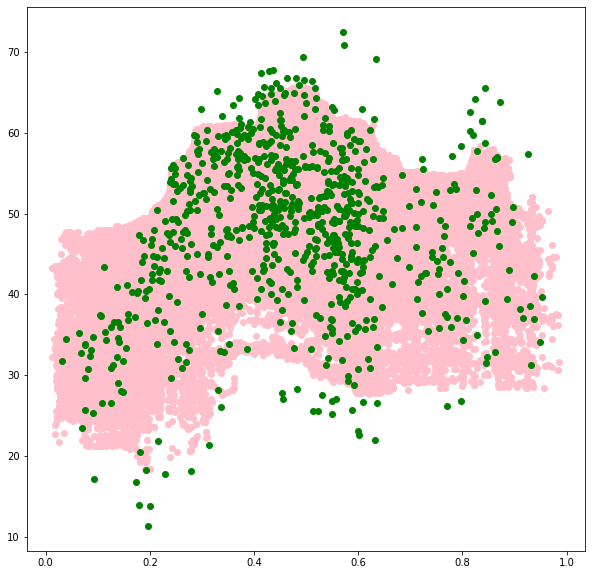

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
# plt.plot(train_csv["yield"], train_csv["yield"], c='black')
# plt.plot(test_csv["yield"], test_csv["yield"], c='black')
# plt.scatter(train_csv["yield"], pred_train, c='blue')
# plt.scatter(test_csv["yield"], pred_test, c='crimson')
plt.scatter(pixel_df["tmean"], pred_pixel, c='pink')
plt.scatter(train_csv["tmean"], train_csv["yield"], c='green')
# plt.xscale("log")
# plt.yscale("log")

(array([  174.,  1414.,  5756.,  9697., 14630., 28417., 34072., 48234.,
        28841., 11983.]),
 array([18.286276, 23.022585, 27.758892, 32.4952  , 37.23151 , 41.96782 ,
        46.70413 , 51.440434, 56.176743, 60.91305 , 65.64936 ],
       dtype=float32),
 <a list of 10 Patch objects>)

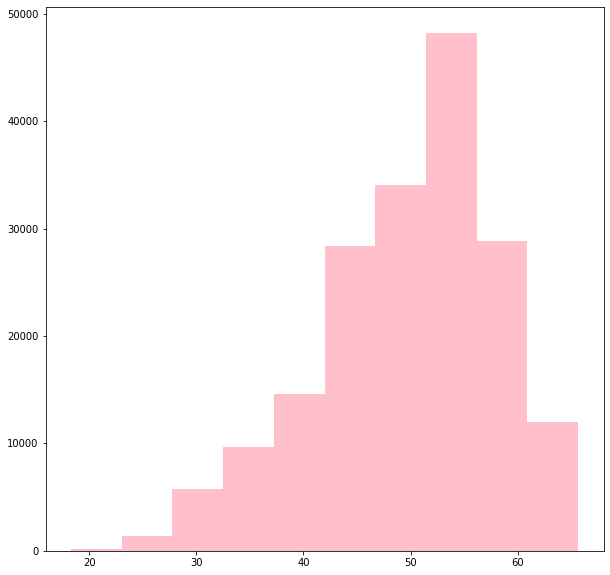

In [85]:
plt.figure(figsize=(10,10))
plt.hist(pred_pixel, facecolor='pink')

(array([ 6.,  6.,  9., 16., 48., 74., 74., 60., 34., 15.]),
 array([23.735634, 27.865376, 31.995117, 36.12486 , 40.2546  , 44.384342,
        48.514084, 52.643826, 56.773567, 60.90331 , 65.03305 ],
       dtype=float32),
 <a list of 10 Patch objects>)

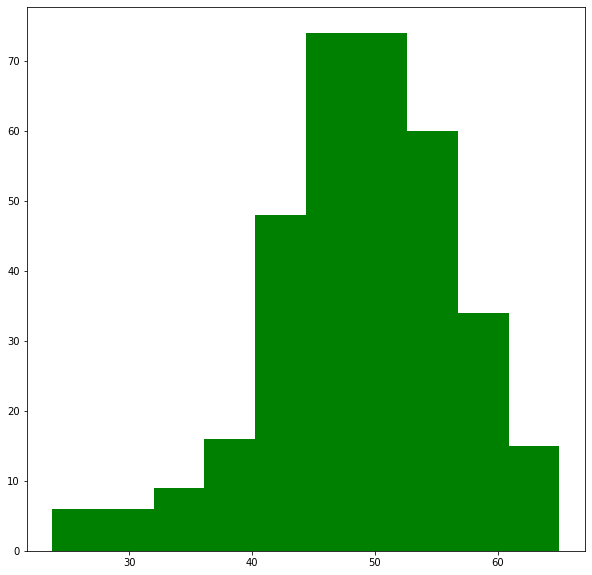

In [86]:
plt.figure(figsize=(10,10))
plt.hist(pred_test, facecolor='g')